In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_05.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_04.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_08.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_01.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_02.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_03.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_07.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_09.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_05/v_biking_05_06.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking_17/v_biking_17_03.mpg
/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg/biking/v_biking

## Importing Libraries


In [2]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from pytube import YouTube
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, ConvLSTM3D,AveragePooling3D, MaxPooling3D,Input
from tensorflow.keras.layers import Bidirectional, ConvLSTM2D,AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, ZeroPadding3D,Dropout,BatchNormalization, LSTM
from PIL import Image
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,SGD
from tensorflow.keras.applications import InceptionV3, DenseNet121, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tqdm import tqdm
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data_dir = '/kaggle/input/ucf11-action-recognize/UCF11_updated_mpg'
categories = os.listdir(data_dir)
num_classes = len(categories)


In [5]:
categories

['biking',
 'trampoline_jumping',
 'swing',
 'walking',
 'golf_swing',
 'soccer_juggling',
 'tennis_swing',
 'volleyball_spiking',
 'basketball',
 'horse_riding',
 'diving']

In [6]:
SEQUENCE_LENGTH = 5
DIM=(224,224)

def load_groups(input_folder):
    groups = []
    label_folders = os.listdir(input_folder)
    index = 0
    for label_folder in sorted(label_folders):
        label_folder_path = os.path.join(input_folder, label_folder)
        if os.path.isdir(label_folder_path):
            group_folders = os.listdir(label_folder_path)
            for group_folder in group_folders:
                if group_folder != 'Annotation':
                    groups.append([os.path.join(label_folder_path, group_folder), label_folder])
            index += 1
    return groups

def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, DIM)
        grayscale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
#         grayscale_frame = cv2.cvtColor(grayscale_frame, cv2.COLOR_GRAY2RGB)
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


def split_into_train_test(groups):
    data = []
    labels = []
    original_labels=[]
    label_to_index = {}  # Create a mapping from labels to integer indices
    index_to_label = {}  # Create a reverse mapping from integer indices to labels

    for group in tqdm(groups):
        video_files = os.listdir(group[0])
        np.random.shuffle(video_files)
        for idx, video_file in enumerate(video_files):
            video_file_path = os.path.abspath(os.path.join(group[0], video_file))
            frames = frames_extraction(video_file_path)  # Extract frames from video
            if len(frames) == SEQUENCE_LENGTH:
                data.append(frames)
                label = group[1]
                original_labels.append(label)
                if label not in label_to_index:
                    index = len(label_to_index)
                    label_to_index[label] = index
                    index_to_label[index] = label
                labels.append(label_to_index[label])

    num_classes = len(label_to_index)
    data=np.asarray(data)
    label = np.array(label)

    encoded_labels = to_categorical(labels, num_classes=num_classes)

    # Split data and labelsencoded_labels
    train_data, test_data, train_labels, test_labels = train_test_split(data, encoded_labels, test_size=0.2, random_state=19, stratify=encoded_labels)

    return train_data, test_data, train_labels, test_labels, original_labels, encoded_labels


def make_csv_file(items, labels, file_path):
    items =[ item.reshape(-1) for item in items]
    labels = [ label.reshape(-1) for label in labels]
    data = {'Video_Frames': items, 'Label': labels}
    df = pd.DataFrame(data)
    df.to_csv(file_path, index=False)



In [7]:
groups = load_groups(data_dir)

In [8]:
train_data, test_data, train_labels, test_labels, original_labels, encoded_labels = split_into_train_test(groups)

100%|██████████| 275/275 [00:49<00:00,  5.51it/s]


In [9]:
make_csv_file(train_data, train_labels, 'final_train_data.csv')
make_csv_file(test_data, test_labels, 'final_test_data.csv')

## Data Visualization of Dataset


In [10]:
train_df = pd.read_csv("/kaggle/working/final_train_data.csv")
test_df = pd.read_csv("/kaggle/working/final_test_data.csv")

In [11]:
train_df.columns,test_df.columns

(Index(['Video_Frames', 'Label'], dtype='object'),
 Index(['Video_Frames', 'Label'], dtype='object'))

In [12]:
train_df.head

<bound method NDFrame.head of                                            Video_Frames  \
0                               [0. 0. 0. ... 0. 0. 0.]   
1     [0.21176471 0.23137255 0.23137255 ... 0.160784...   
2     [0.         0.03921569 0.03529412 ... 0.203921...   
3                               [0. 0. 0. ... 0. 0. 0.]   
4     [0.03921569 0.04313725 0.03137255 ... 0.152941...   
...                                                 ...   
1272                            [0. 0. 0. ... 0. 0. 0.]   
1273  [0.70196078 0.59607843 0.53333333 ... 0.360784...   
1274  [0.13333333 0.11764706 0.10196078 ... 0.568627...   
1275  [0.09019608 0.13333333 0.10980392 ... 0.909803...   
1276  [0.58039216 0.63137255 0.64313725 ... 0.250980...   

                                   Label  
0     [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  
1     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  
2     [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  
3     [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  
4     [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]  
...

In [13]:
test_df.head

<bound method NDFrame.head of                                           Video_Frames  \
0                              [0. 0. 0. ... 0. 0. 0.]   
1    [0.07058824 0.02352941 0.00392157 ... 0.      ...   
2    [0.67058824 0.64313725 0.55294118 ... 0.396078...   
3    [0.36078431 0.2627451  0.16862745 ... 0.796078...   
4    [0.74509804 0.8        0.8        ... 0.019607...   
..                                                 ...   
315                            [0. 0. 0. ... 0. 0. 0.]   
316  [0.94117647 0.94901961 0.95686275 ... 0.254901...   
317  [0.16470588 0.2        0.32941176 ... 0.015686...   
318  [0.47058824 0.43529412 0.52941176 ... 0.007843...   
319  [0.         0.02352941 0.01960784 ... 0.160784...   

                                  Label  
0    [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]  
1    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  
2    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  
3    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]  
4    [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  
..                   

In [14]:
print(f"Dimension of Training Datset is : {train_df.shape}")
print(f"Dimension of Training Datset is : {test_df.shape}")

Dimension of Training Datset is : (1277, 2)
Dimension of Training Datset is : (320, 2)


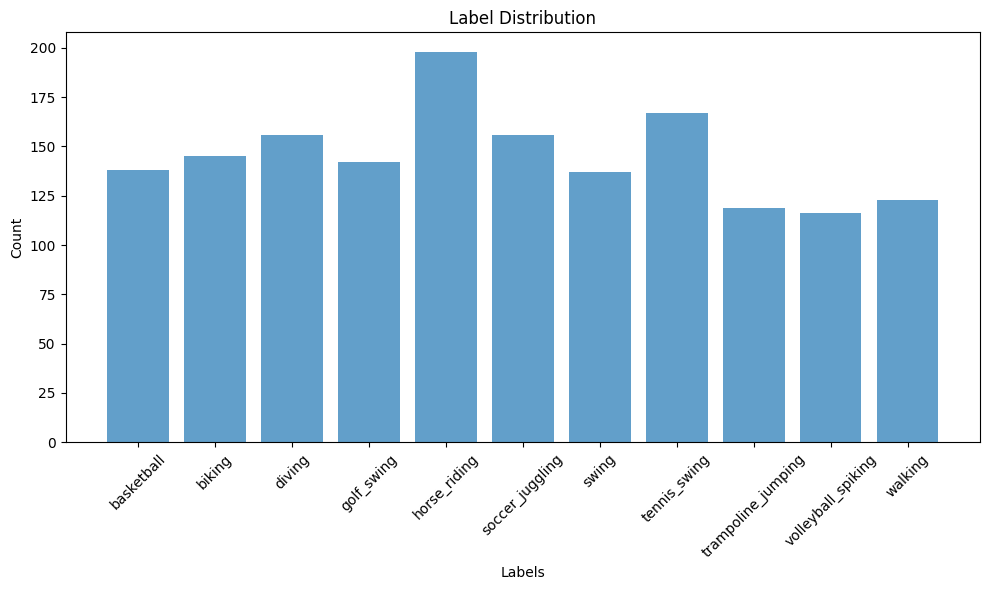

In [15]:
from collections import Counter

def create_bar_plot(labels):
    # Count the occurrences of each unique label
    label_counts = Counter(labels)
    
    # Get the unique labels and their counts
    unique_labels, counts = zip(*label_counts.items())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, align='center', alpha=0.7)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    plt.show()
    
create_bar_plot(original_labels)

## Making CNN+LSTM Model for Training 

##### Defining the Dimesnsion of input

In [16]:
frames = SEQUENCE_LENGTH   
height = DIM[0]
width = DIM[1]
num_classes=11

In [17]:
def SEQ_Model():
    model = Sequential()
    
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(frames, height, width, 3),
                         strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(frames, height, width, 3),
                         strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten())  
    

    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2=0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(2024, activation='relu', kernel_regularizer=l2(l2=0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model
    

In [18]:
def cnn_lstm_model():
    base_architecture = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_architecture = Model(inputs=base_architecture.input, outputs=base_architecture.get_layer('mixed7').output)

    for layer in base_architecture.layers:
        layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(base_architecture, input_shape=(SEQUENCE_LENGTH, 224, 224, 3)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    return model

In [19]:
print("Model Architecture : ")
final_model= cnn_lstm_model()

Model Architecture : 
87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 12, 12, 768)   8975264   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 110592)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 5, 64)             28328192  
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             12416     
                                                                 
 flatten_1 (Flatten)         (None, 160)               0         
                                   

## Structure of Model Architecture

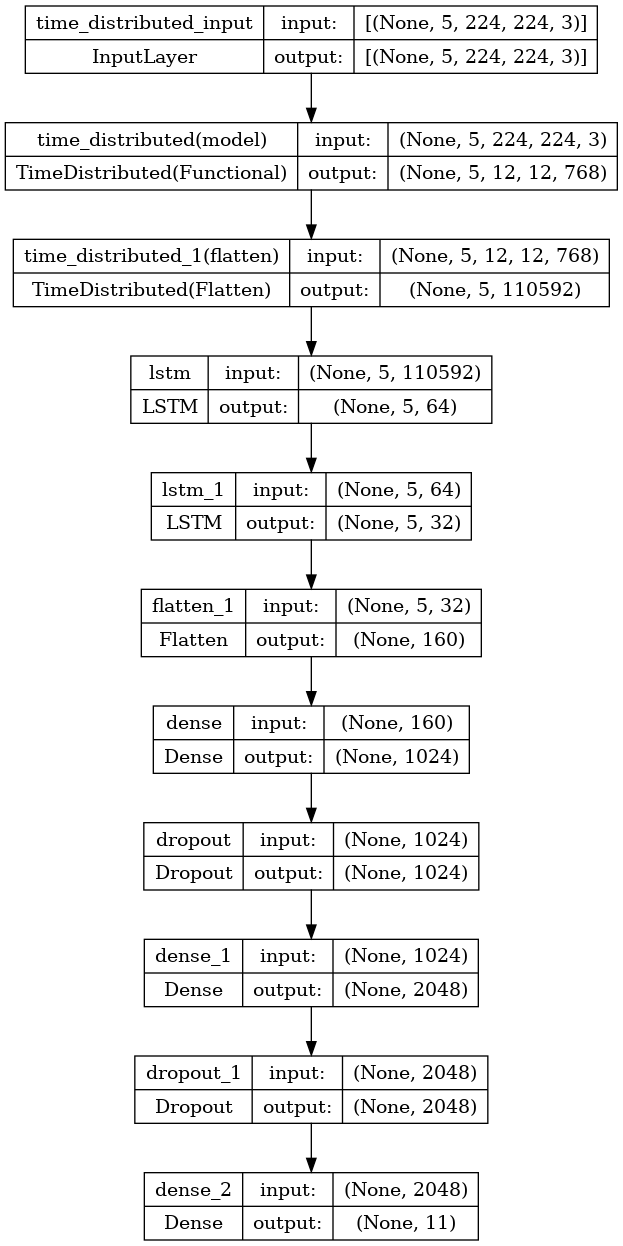

In [20]:
model_str = plot_model(final_model, to_file='model.png', show_shapes=True, show_layer_names=True)
model_str

## Compile and Train the Model

In [21]:
# early_stopper = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=40,
#     mode='auto',
#     restore_best_weights=True,
# )

optimizer = tf.keras.optimizers.SGD(learning_rate=0.002,momentum=0.9,nesterov=True,weight_decay=0.025,use_ema=True,ema_overwrite_frequency=5)

final_model.compile(optimizer=optimizer,  
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  

model_history = final_model.fit(
    train_data,
    train_labels,
    batch_size=25,
    epochs=150,
    verbose='auto',
    validation_split = 0.2,
    shuffle=True,
    use_multiprocessing=True
#     ,callbacks=early_stopper
)

Epoch 1/150
41/41 [==============================] - 38s 464ms/step - loss: 2.3940 - accuracy: 0.1009 - val_loss: 2.3942 - val_accuracy: 0.1133
Epoch 2/150
41/41 [==============================] - 11s 273ms/step - loss: 2.3930 - accuracy: 0.1156 - val_loss: 2.3898 - val_accuracy: 0.1719
Epoch 3/150
41/41 [==============================] - 11s 277ms/step - loss: 2.3876 - accuracy: 0.1283 - val_loss: 2.3860 - val_accuracy: 0.1914
Epoch 4/150
41/41 [==============================] - 11s 277ms/step - loss: 2.3856 - accuracy: 0.1410 - val_loss: 2.3826 - val_accuracy: 0.2031
Epoch 5/150
41/41 [==============================] - 11s 281ms/step - loss: 2.3850 - accuracy: 0.1381 - val_loss: 2.3872 - val_accuracy: 0.2109
Epoch 6/150
41/41 [==============================] - 12s 284ms/step - loss: 2.3829 - accuracy: 0.1440 - val_loss: 2.3832 - val_accuracy: 0.1992
Epoch 7/150
41/41 [==============================] - 12s 292ms/step - loss: 2.3791 - accuracy: 0.1450 - val_loss: 2.3790 - val_accuracy:

## Model Evaluation


In [22]:
test_loss,test_accuracy = final_model.evaluate(test_data,test_labels)

10/10 [==============================] - 8s 284ms/step - loss: 0.4626 - accuracy: 0.9375


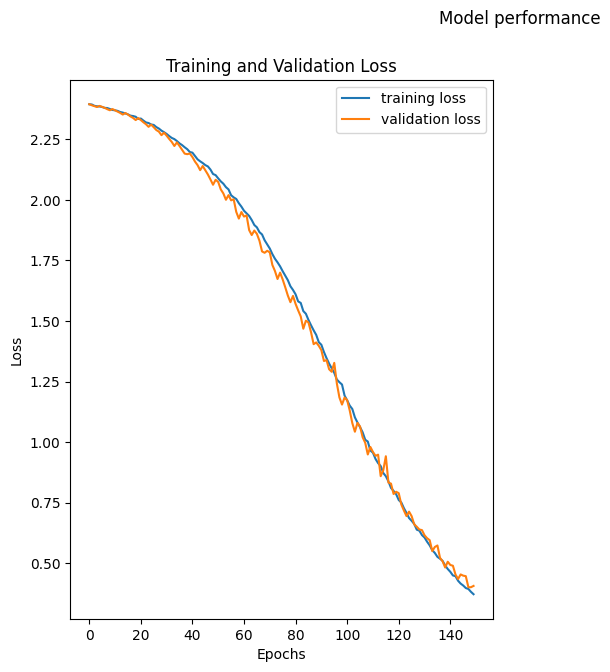

In [23]:
plt.figure(figsize=(12,7))
plt.suptitle("Model performance")

plt.subplot(1, 2, 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.plot(model_history.history["loss"], label="training loss")
plt.plot(model_history.history["val_loss"], label="validation loss")
plt.legend()


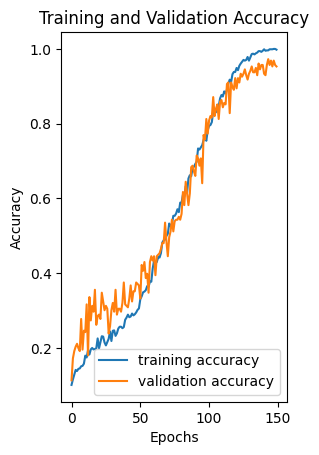

In [24]:
plt.subplot(1, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.plot(model_history.history['accuracy'], label="training accuracy")
plt.plot(model_history.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

In [25]:
SGD_HAR3 = final_model.save("IV3_LSTM4.h5")
SGD_HAR_wt3 = final_model.save_weights("IV3_LSTM4_wt.h5")

In [26]:
class_labels = ["basketball", "biking", "diving", "golf", "horse_riding",
                "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
                "volleyball_spiking", "walking"]

def download_youtube_frames(youtube_url):

    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    video_path = os.path.join("/kaggle/working", 'video.mp4')
    stream.download(output_path="/kaggle/working", filename='video')
    return video_path

def predict_single_action(input_video_file_path, SEQUENCE_LENGTH):
    frames = frames_extraction(input_video_file_path)
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(frames[i])
        plt.axis('off')
    plt.show()
    frames = np.asarray(frames)
    frames = frames.reshape(-1, SEQUENCE_LENGTH, DIM[0], DIM[1], 3)
    
    prediction = final_model.predict(frames)
    print(prediction)
    predicted_label = np.argmax(prediction, axis=1)
    
    print("Predicted label: ", predicted_label)
    print("Predicted Action: ", class_labels[predicted_label[0]])
    
    return predicted_label[0]


##basketball
# video_link = 'https://www.youtube.com/watch?v=VZsrT08QHto'

#diving-swimming
# video_link= 'https://youtube.com/shorts/ePaEhSVi4bY?feature=shared'


#golf
video_link= 'https://youtube.com/shorts/bJcULhp4-78?feature=shared'

# ##soccer
# video_link = "https://youtube.com/shorts/OUxsdZ71fAc?feature=shared"


video_path = download_youtube_frames(video_link)

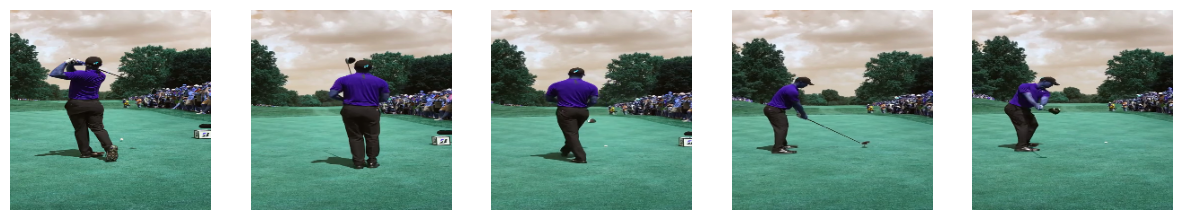

1/1 [==============================] - 3s 3s/step
[[0.00837707 0.00298536 0.00331303 0.65530705 0.0139759  0.20594868
  0.00963544 0.05104622 0.00731603 0.01559552 0.02649967]]
Predicted label:  [3]
Predicted Action:  golf


In [27]:
input_video_file_path = '/kaggle/working/video'
final_output = predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

10/10 [==============================] - 3s 284ms/step
[[25  0  0  0  0  1  0  1  0  1  0]
 [ 0 29  0  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  1  0  0  1  0]
 [ 0  0  0 23  0  5  0  0  0  0  0]
 [ 0  0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  1  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  1  0 23  0  0]
 [ 0  0  1  0  0  1  0  0  0 21  0]
 [ 0  2  0  0  0  3  0  0  1  0 19]]


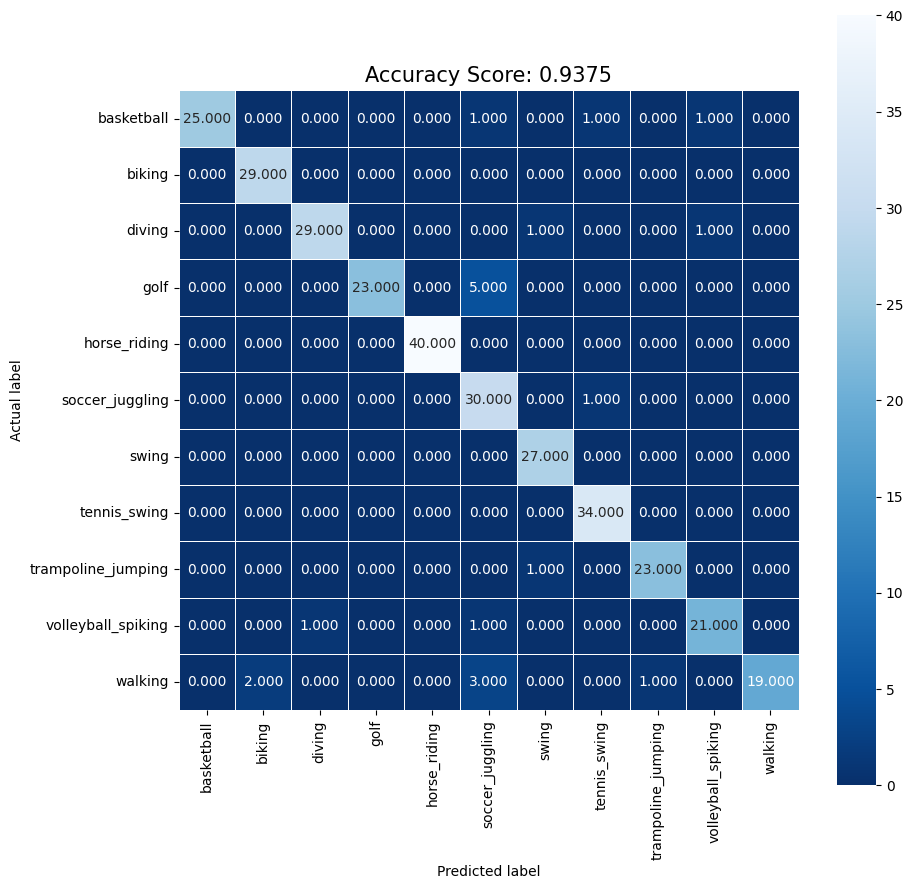

In [28]:
# confusion matrix in range 0 to 1 and us original labels at graph at display martix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ["basketball", "biking", "diving", "golf", "horse_riding",
                "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
                "volleyball_spiking", "walking"]

predicted_label = final_model.predict(test_data)
predicted_label = np.argmax(predicted_label, axis=1)

cm = confusion_matrix(test_labels.argmax(axis=1), predicted_label)
print(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r',xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
plt.title(all_sample_title, size=15)
plt.show()
